# Compare model output with ASTE and observations

First plots individual moorings/profiles to generate time series for comparison with CANARI-LE

In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import utils
import pickle

In [2]:
%matplotlib inline

In [3]:
profile_dir='~/canari/users/emmomp/ASTE-profiles'

In [63]:
moorings={'Davis':'davisstraitmooring_llc270_18x18_nov2014_ASTE_model.nc',
         'Fram':'framstraitmooringuEvN_llc270_18x18_sep2015_ASTE_model.nc',
         'OSNAP':'osnap_llc270_18x18_allmooringdata_jan2019_ASTE_model.nc'}
# Which prof_point(s) to sub-select from mooring data
with open('../data/moooring_points.pickle','rb') as file:
        mooring_points=pickle.load(file)
print(mooring_points)

{'Davis': [845576.0], 'Fram': 925687.0, 'OSNAP': []}


In [64]:
mooring='OSNAP'
profile_test=xr.open_dataset(f'{profile_dir}/{moorings[mooring]}')

In [65]:
profile_test=profile_test.set_coords(['prof_YYYYMMDD','prof_HHMMSS','prof_descr','prof_basin','prof_point'])
coords=['prof_depth','prof_date','prof_lon','prof_lat','prof_YYYYMMDD','prof_HHMMSS','prof_descr','prof_basin','prof_point']
for var in profile_test:
    if var[:11]=='prof_interp':
        coords.append(var)
profile_test=profile_test.set_coords(coords) 
#coords

In [66]:
profile_test_clean=profile_test.where(np.isfinite(profile_test.prof_Testim.mean('iDEPTH')),drop=True)
profile_test_clean

<xarray.Dataset> Size: 405MB
Dimensions:              (iPROF: 33272, iDEPTH: 75, iINTERP: 1)
Coordinates: (12/18)
    prof_depth           (iDEPTH) float64 600B ...
    prof_descr           (iPROF) |S30 998kB b'OM6.-1874....-2014070520150516'...
    prof_date            (iPROF) float64 266kB 7.358e+05 7.358e+05 ... 7.365e+05
    prof_YYYYMMDD        (iPROF) float64 266kB 2.014e+07 2.014e+07 ... 2.016e+07
    prof_HHMMSS          (iPROF) float64 266kB 1.2e+05 1.2e+05 ... 1.2e+05
    prof_lon             (iPROF) float64 266kB -51.69 -51.69 ... -12.33 -12.33
    ...                   ...
    prof_interp_YCNINJ   (iPROF) float64 266kB 50.33 50.33 50.33 ... 60.19 60.19
    prof_interp_i        (iPROF, iINTERP) float64 266kB ...
    prof_interp_j        (iPROF, iINTERP) float64 266kB ...
    prof_interp_lon      (iPROF, iINTERP) float64 266kB ...
    prof_interp_lat      (iPROF, iINTERP) float64 266kB ...
    prof_interp_weights  (iPROF, iINTERP) float64 266kB ...
Dimensions without coordinates: iPROF, iDEPTH, iINTERP
Data variables: (12/20)
    prof_T               (iPROF, iDEPTH) float64 20MB nan nan nan ... nan nan
    prof_Tweight         (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
    prof_Testim          (iPROF, iDEPTH) float64 20MB 6.193 4.785 ... nan nan
    prof_Terr            (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
    prof_Tflag           (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
    prof_S               (iPROF, iDEPTH) float64 20MB nan nan nan ... nan nan
    ...                   ...
    prof_Uflag           (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
    prof_V               (iPROF, iDEPTH) float64 20MB nan nan nan ... nan nan
    prof_Vweight         (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
    prof_Vestim          (iPROF, iDEPTH) float64 20MB -0.1991 -0.1487 ... nan
    prof_Verr            (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
    prof_Vflag           (iPROF, iDEPTH) float64 20MB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    Format:   The contents of this MITprof file were processed \nusing the MI...
    date:     31-Jul-2019

In [67]:
prof_filt=profile_test_clean.where(np.isfinite(profile_test_clean.prof_T),drop=True).mean('iDEPTH')

In [68]:
prof_filt=prof_filt.assign_coords({'time':('iPROF',np.datetime64('0000-01-01')+prof_filt.prof_date.data.astype('timedelta64[D]'))})

/tmp/ipykernel_554/1180295723.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  prof_filt=prof_filt.assign_coords({'time':('iPROF',np.datetime64('0000-01-01')+prof_filt.prof_date.data.astype('timedelta64[D]'))})


In [69]:
point_depths=profile_test_clean.prof_depth.where(np.isfinite(profile_test_clean.prof_T)).groupby(profile_test_clean.prof_point).mean(['iPROF','iDEPTH'])

In [70]:
# Get number of tiles to plot from number of unique points
nn=np.sqrt(len(set(prof_filt.prof_point.data)))
nn=int(np.ceil(nn))

If no mooring points specified, plot locations and all time series to choose mooring

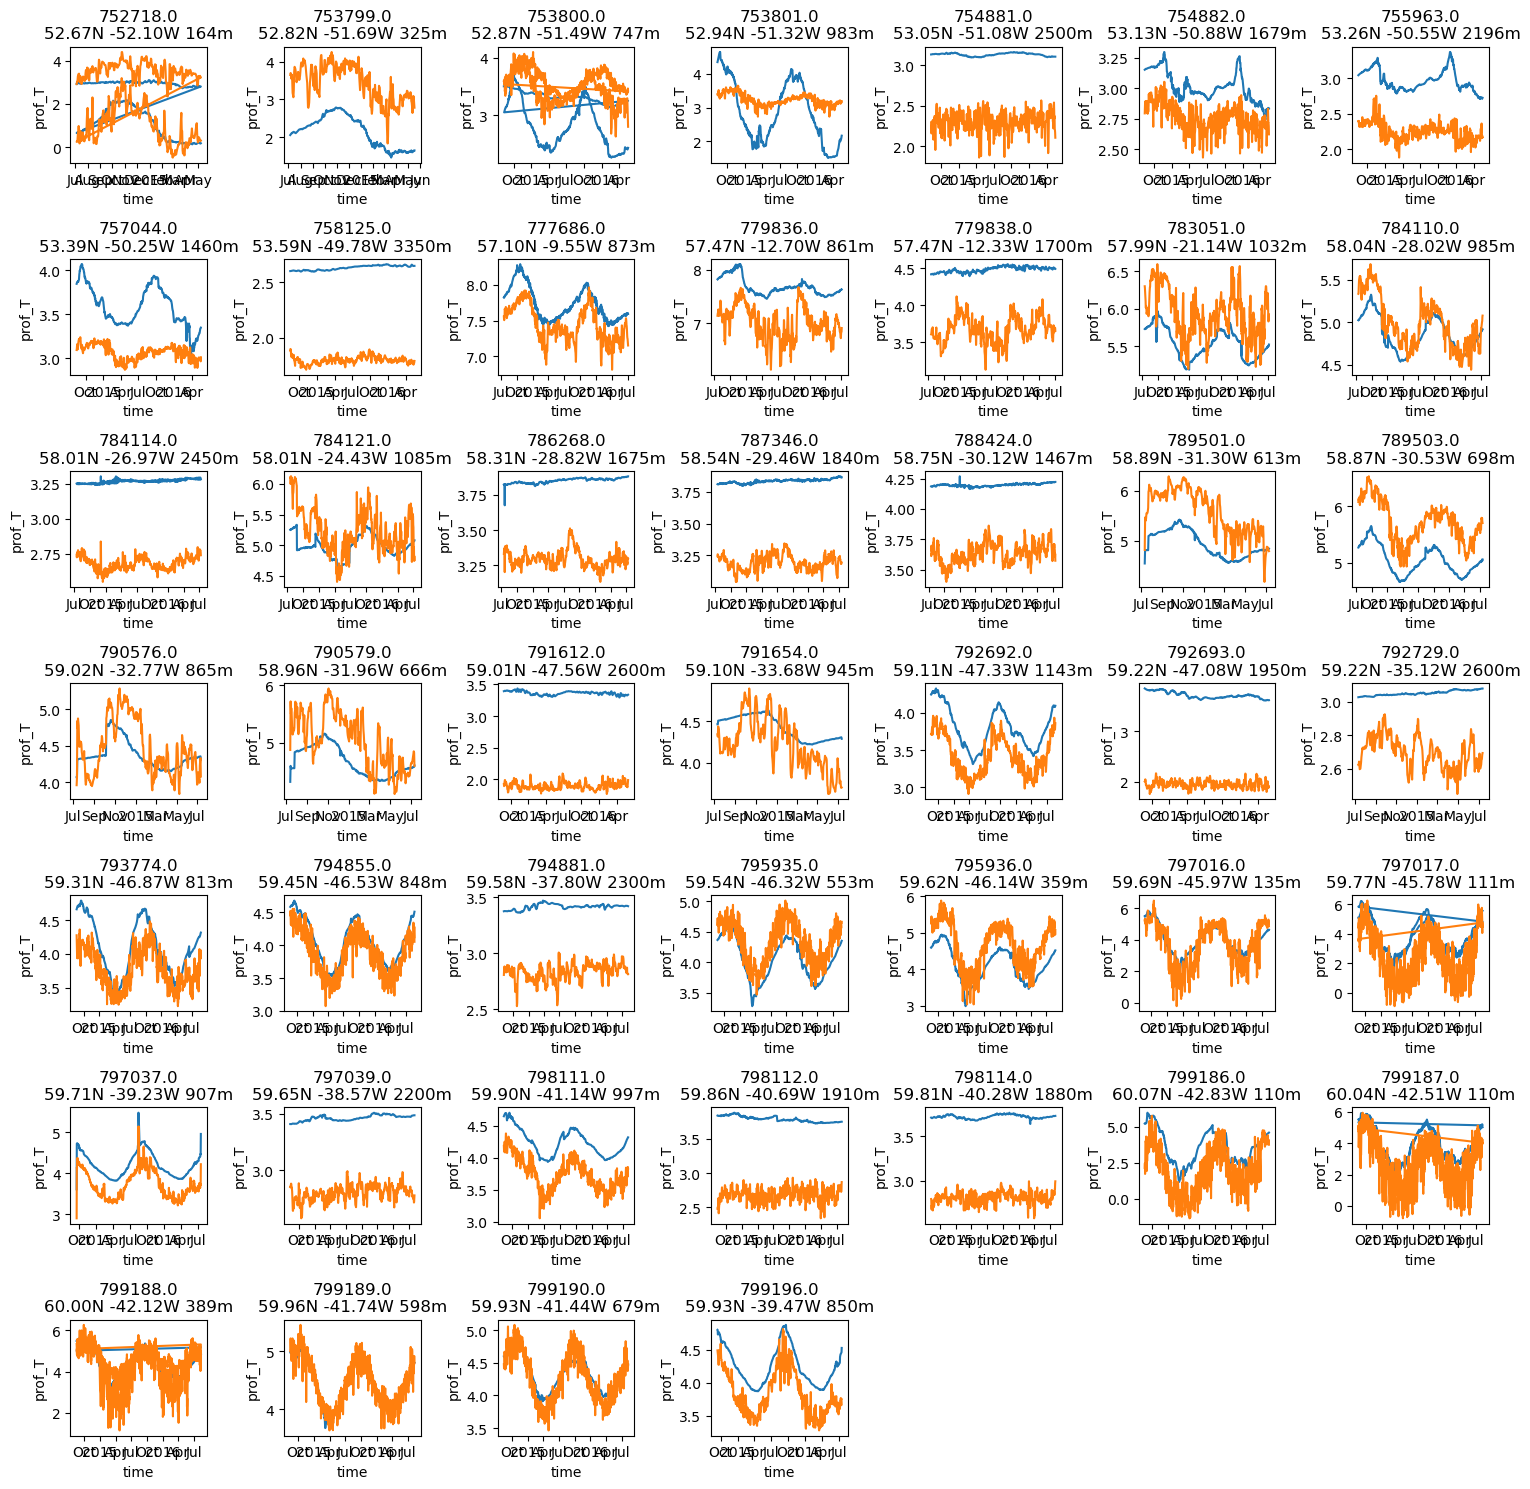

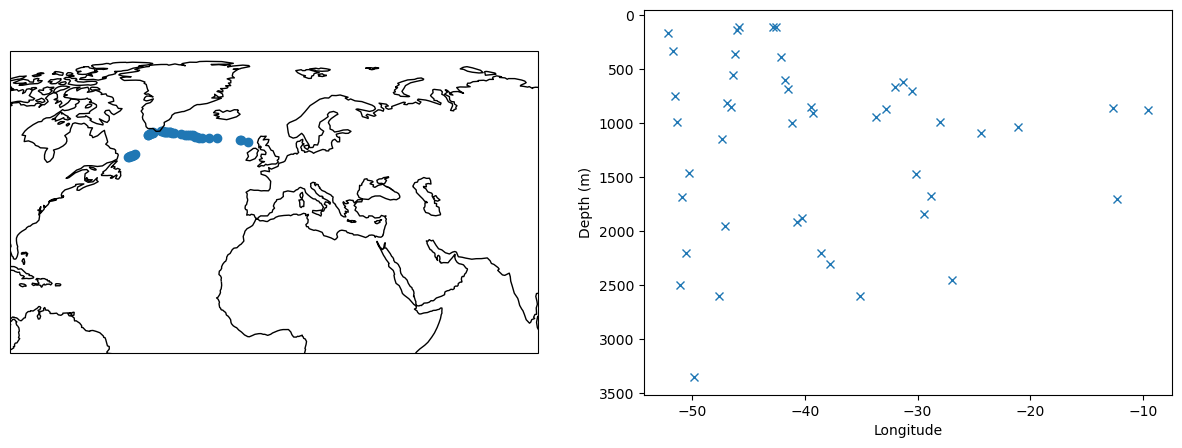

Provide mooring points, seperated by commas 753801,799189


In [86]:
if not mooring_points[mooring]: # check if mooring_points is empty, if so need to choose mooring
    prof_filt_group=prof_filt.groupby(prof_filt.prof_point)
    ipp=1
    plt.figure(figsize=[15,15])
    point_lons=[]
    point_lats=[]
    for pp,pd in prof_filt_group:
        point_lons.append(pd.prof_lon.mean())
        point_lats.append(pd.prof_lat.mean())
        plt.subplot(nn,nn,ipp)
        pd.prof_Testim.plot(x='time')
        pd.prof_T.plot(x='time')
        plt.title(f'{pp}\n{pd.prof_lat.mean():2.2f}N {pd.prof_lon.mean():2.2f}W {point_depths.sel(prof_point=pp):2.0f}m')
        ipp+=1
    plt.tight_layout()

    #proj=ccrs.Orthographic(central_longitude=-30,central_latitude=30)
    plt.figure(figsize=[15,5])
    proj=ccrs.Robinson()
    ax=plt.subplot(1,2,1,projection=proj)
    ax.scatter(x=point_lons,y=point_lats,transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-80,80,0,90],ccrs.PlateCarree())
    ax=plt.subplot(1,2,2)
    ax.plot(point_lons,point_depths,'x')
    ax.invert_yaxis()
    plt.xlabel('Longitude')
    plt.ylabel('Depth (m)')
    
    plt.show()
    
    mooring_points[mooring]=[float(x) for x in input('Provide mooring points, seperated by commas').split(',')]
    with open('../data/moooring_points.pickle','wb') as file:
        pickle.dump(mooring_points,file)


Take chosen points only

In [90]:
prof_all=[]
for point in mooring_points[mooring]:
    prof_0=prof_filt.where(prof_filt.prof_point==point,drop=True).squeeze()
    prof_0=prof_0.assign_coords({'depth':point_depths.sel(prof_point=point),'loc':f'{mooring} Mooring','point':point})
    prof_0=prof_0.swap_dims({'iPROF':'time'})
    prof_all.append(prof_0)
prof_all=xr.concat(prof_all,'point')
prof_all.to_netcdf(f'../data/{mooring}_tseries.nc')
print(prof_all)

<xarray.Dataset> Size: 425kB
Dimensions:              (time: 728, point: 2)
Coordinates: (12/21)
  * time                 (time) datetime64[ns] 6kB 2014-08-12 ... 2016-08-08
    prof_descr           (point, time) object 12kB b'OM8.-KPO_1112-11111111  ...
    prof_date            (point, time) float64 12kB 7.358e+05 ... 7.365e+05
    prof_YYYYMMDD        (point, time) float64 12kB 2.014e+07 ... 2.016e+07
    prof_HHMMSS          (point, time) float64 12kB 1.2e+05 1.2e+05 ... 1.2e+05
    prof_lon             (point, time) float64 12kB -51.32 -51.32 ... -41.74
    ...                   ...
    prof_interp_lon      (point, time) float64 12kB -51.17 -51.17 ... -41.78
    prof_interp_lat      (point, time) float64 12kB 52.88 52.88 ... 60.0 60.0
    prof_interp_weights  (point, time) float64 12kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    depth                (point) float64 16B 983.3 597.7
    loc                  <U13 52B 'OSNAP Mooring'
  * point                (point) float64 16B 7.538e+05 7.992e+05

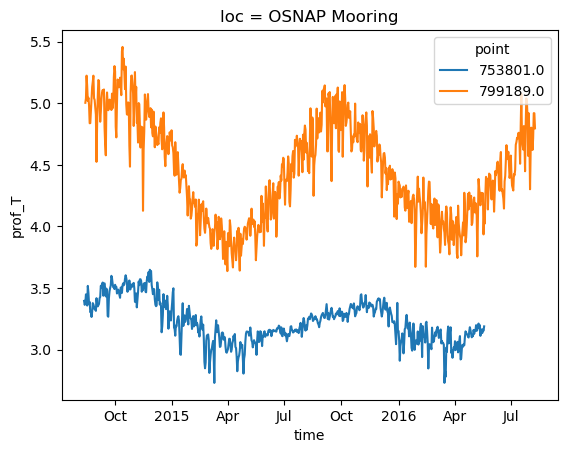

In [91]:
prof_all.prof_T.plot(x='time',hue='point')

In [12]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly"
nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"

Tdata=[]
for year in range(int(prof_0.time.dt.year.min()),int(prof_0.time.dt.year.min())+1):
    temp_Tgrid = f"{data_path}/{year}/cv575o_1_mon__grid_T_votemper.nc"
    sal_Tgrid = f"{data_path}/{year}/cv575o_1_mon__grid_T_vosaline.nc"
    Tdata.append(xr.open_mfdataset([temp_Tgrid,sal_Tgrid]))
Tdata=xr.concat(Tdata,'time_counter')

In [15]:
import coast
config_grid={}
config_dir="../../tutorials/config"
for grid in ['t','f','u','v']:
    config_grid[grid]=f'{config_dir}/example_nemo_grid_{grid}.json'

nemo_t = coast.Gridded( fn_domain=nemo_dom, config=config_grid['t'])

/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages

In [80]:
[yy,xx]=nemo_t.find_j_i(lat=prof_0.prof_lat.mean(),lon=prof_0.prof_lon.mean())
zz=np.abs(Tdata.deptht-prof_0_depth.values).argmin()
Tplot=Tdata.isel(x=xx,y=yy,deptht=zz)
Tplot

/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/xarray/core/dataarray.py:6047: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().


<xarray.Dataset> Size: 892B
Dimensions:              (time_counter: 12, axis_nbounds: 2, nvertex: 4)
Coordinates:
  * time_counter         (time_counter) object 96B 2002-01-16 00:00:00 ... 20...
    deptht               float32 4B 86.93
    y                    float64 8B 1.039e+03
    x                    float64 8B 948.0
    nav_lat              float32 4B dask.array<chunksize=(), meta=np.ndarray>
    nav_lon              float32 4B dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds) object 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bounds        (time_counter, axis_nbounds) float32 96B dask.array<chunksize=(12, 2), meta=np.ndarray>
    bounds_nav_lat       (time_counter, nvertex) float32 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
    bounds_nav_lon       (time_counter, nvertex) float32 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
    vosaline             (time_counter) float32 48B dask.array<chunksize=(1,), meta=np.ndarray>
    votemper             (time_counter) float32 48B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

In [81]:
datetimeindex = Tplot.indexes['time_counter'].to_datetimeindex()
Tplot['time_counter']=datetimeindex

/tmp/ipykernel_2219/1941892365.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Text(0.5, 1.0, 'Salinity')

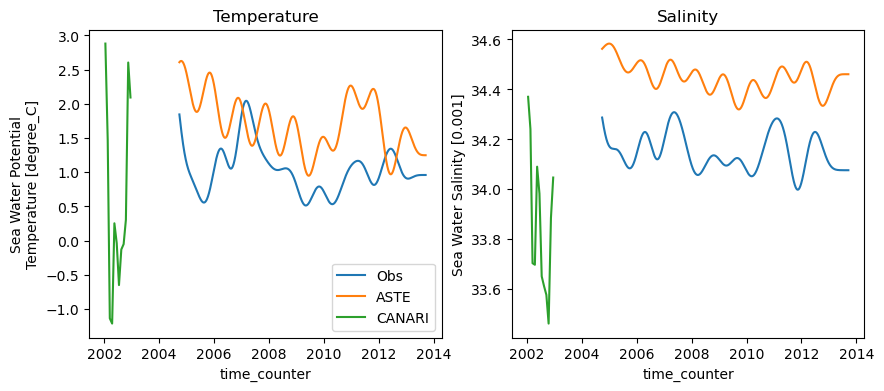

In [82]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
utils.butter_ufunc(prof_0.prof_T,365,'iPROF').plot(x='time')
utils.butter_ufunc(prof_0.prof_Testim,365,'iPROF').plot(x='time')
Tplot.votemper.plot(x='time_counter')
plt.legend(['Obs','ASTE','CANARI'])
plt.title('Temperature')
plt.subplot(1,2,2)
utils.butter_ufunc(prof_0.prof_S,365,'iPROF').plot(x='time')
utils.butter_ufunc(prof_0.prof_Sestim,365,'iPROF').plot(x='time')
Tplot.vosaline.plot(x='time_counter')
plt.title('Salinity')